<a href="https://colab.research.google.com/github/binary01/GoldenIA/blob/main/GoldenIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math

# التحقق من وجود GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
class GoldenSimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(GoldenSimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        # تخزين الأوزان الأولية (المعرفة الأساسية)
        self.W0 = {
            'fc1.weight': self.fc1.weight.data.clone(),
            'fc1.bias': self.fc1.bias.data.clone(),
            'fc2.weight': self.fc2.weight.data.clone(),
            'fc2.bias': self.fc2.bias.data.clone()
        }

        self.phi = 1.618  # النسبة الذهبية
        self.n_min = 1.0 / (self.phi - 1)
        self.n_max = 1000 * self.n_min

    def forward(self, x):
        x = x.view(-1, 784)  # تسطيح الصور
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def compute_alpha(self, n):
        """حساب معامل التوازن الذهبي"""
        if n <= self.n_min:
            return 1.0
        elif n >= self.n_max:
            return self.phi + 0.05
        else:
            return (1 + self.phi * n) / n

    def golden_update(self, gradients, n_samples, epoch, lr=0.01):
        """تحديث الأوزان باستخدام الخوارزمية الذهبية"""
        alpha = self.compute_alpha(n_samples)
        lambda_t = 0.1 * math.exp(-0.01 * epoch)  # اضمحلال زمني

        with torch.no_grad():
            for name, param in self.named_parameters():
                if name in self.W0 and name in gradients:
                    # المكون الذهبي
                    golden_component = alpha * self.W0[name] + (1 - alpha) * param.data

                    # التحديث التقليدي
                    traditional_update = param.data - lr * gradients[name]

                    # الدمج الذكي
                    param.data = (1 - lambda_t) * golden_component + lambda_t * traditional_update

In [ ]:
class GoldenTrainer:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.history = {
            'loss': [], 'accuracy': [], 'alpha': [],
            'stability': [], 'adaptability': []
        }

    def train_epoch(self, train_loader, epoch, lr=0.01):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)

            # forward pass
            output = self.model(data)
            loss = F.cross_entropy(output, target)

            # backward pass - حساب المتجهات
            self.model.zero_grad()
            loss.backward()

            # تخزين المتجهات للتحديث الذهبي
            gradients = {name: param.grad.clone() for name, param in self.model.named_parameters()}

            # التحديث الذهبي
            n_samples = len(data)
            self.model.golden_update(gradients, n_samples, epoch, lr)

            # إحصائيات
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += len(data)

            # حساب مقاييس الذهبية
            alpha = self.model.compute_alpha(n_samples)
            stability = alpha
            adaptability = 1 - alpha

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch} | Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f} | Alpha: {alpha:.3f}')

        accuracy = 100. * correct / total
        avg_loss = total_loss / len(train_loader)

        # حفظ التاريخ
        self.history['loss'].append(avg_loss)
        self.history['accuracy'].append(accuracy)
        self.history['alpha'].append(alpha)
        self.history['stability'].append(stability)
        self.history['adaptability'].append(adaptability)

        return avg_loss, accuracy

    def evaluate(self, test_loader):
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += len(data)

        test_loss /= total
        accuracy = 100. * correct / total

        print(f'\nTest Results: Average loss: {test_loss:.4f}, '
              f'Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')

        return test_loss, accuracy

    def plot_training_history(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

        # فقدان
        ax1.plot(self.history['loss'])
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')

        # دقة
        ax2.plot(self.history['accuracy'])
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')

        # ألفا
        ax3.plot(self.history['alpha'])
        ax3.set_title('Alpha Value Over Time')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Alpha')
        ax3.axhline(y=1.618, color='r', linestyle='--', label='Golden Ratio')
        ax3.legend()

        # الاستقرار vs التكيف
        ax4.plot(self.history['stability'], label='Stability')
        ax4.plot(self.history['adaptability'], label='Adaptability')
        ax4.set_title('Stability vs Adaptability')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Score')
        ax4.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
class TraditionalNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(TraditionalNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def compare_models():
    """مقارنة بين النموذج الذهبي والتقليدي"""
    # تنفيذ مشابه مع Adam optimizer للنموذج التقليدي
    # وحساب الأداء على بيانات اختبارية صغيرة وكبيرة
    pass

Starting Golden-AI Training...
Epoch: 1 | Batch: 0/16 | Loss: 2.2862 | Alpha: 1.634

Test Results: Average loss: 2.3452, Accuracy: 752/10000 (7.52%)

Epoch 01: Train Loss: 2.3316, Train Acc: 8.50%, Test Acc: 7.52%
--------------------------------------------------
Epoch: 2 | Batch: 0/16 | Loss: 2.2506 | Alpha: 1.634

Test Results: Average loss: 2.3450, Accuracy: 762/10000 (7.62%)

Epoch 02: Train Loss: 2.3313, Train Acc: 8.50%, Test Acc: 7.62%
--------------------------------------------------
Epoch: 3 | Batch: 0/16 | Loss: 2.2432 | Alpha: 1.634

Test Results: Average loss: 2.3450, Accuracy: 763/10000 (7.63%)

Epoch 03: Train Loss: 2.3327, Train Acc: 8.60%, Test Acc: 7.63%
--------------------------------------------------
Epoch: 4 | Batch: 0/16 | Loss: 2.3483 | Alpha: 1.634

Test Results: Average loss: 2.3454, Accuracy: 753/10000 (7.53%)

Epoch 04: Train Loss: 2.3313, Train Acc: 8.80%, Test Acc: 7.53%
--------------------------------------------------
Epoch: 5 | Batch: 0/16 | Loss: 2.

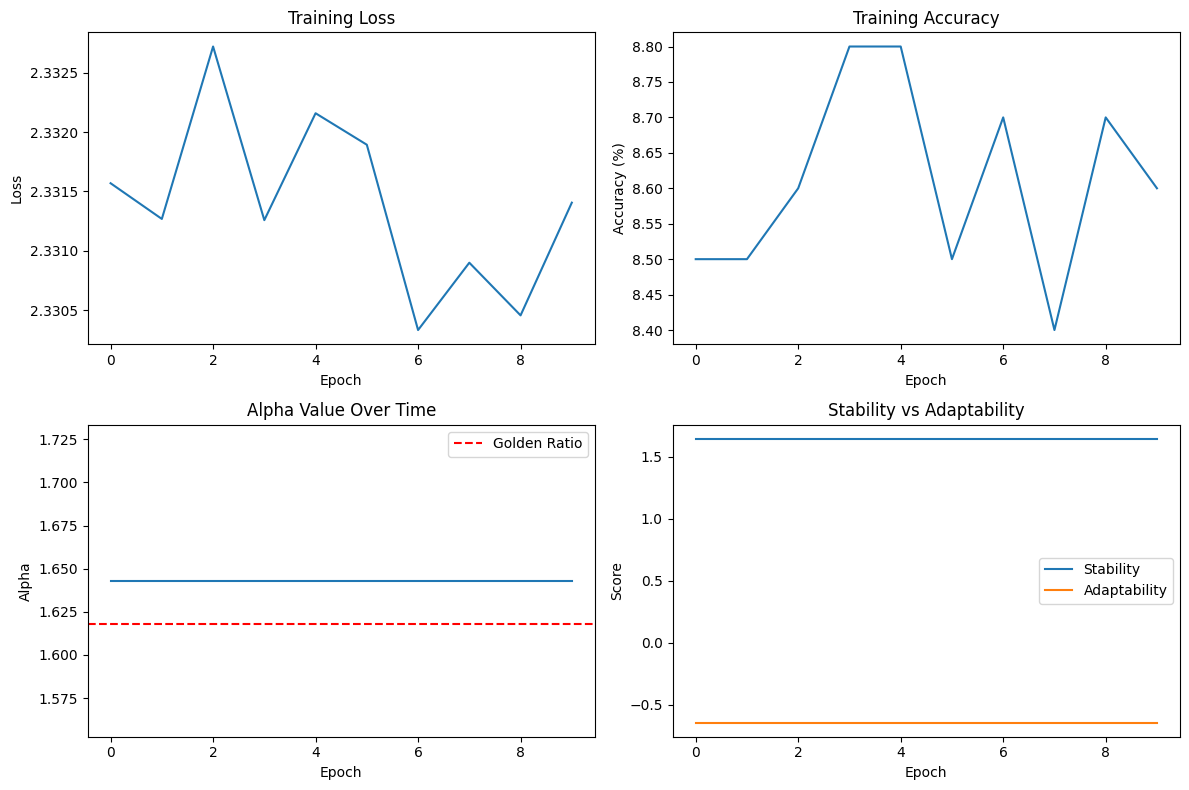


🎯 FINAL RESULTS:
Final Alpha: 1.643
Golden Score: 0.500
Final Training Accuracy: 8.60%


In [ ]:
def main():
    # تحميل البيانات
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    # عينات قليلة لمحاكاة سيناريو البيانات المحدودة
    small_train_dataset = torch.utils.data.Subset(train_dataset, range(1000))

    train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

    # تهيئة النموذج والمدرب
    model = GoldenSimpleNN()
    trainer = GoldenTrainer(model, device)

    # التدريب
    epochs = 10
    print("Starting Golden-AI Training...")
    print("=" * 50)

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = trainer.train_epoch(train_loader, epoch)
        test_loss, test_acc = trainer.evaluate(test_loader)

        print(f'Epoch {epoch:02d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Acc: {test_acc:.2f}%')
        print("-" * 50)

    # عرض النتائج
    trainer.plot_training_history()

    # تقرير نهائي
    final_alpha = trainer.history['alpha'][-1]
    golden_score = (trainer.history['stability'][-1] + trainer.history['adaptability'][-1]) / 2

    print(f"\n🎯 FINAL RESULTS:")
    print(f"Final Alpha: {final_alpha:.3f}")
    print(f"Golden Score: {golden_score:.3f}")
    print(f"Final Training Accuracy: {trainer.history['accuracy'][-1]:.2f}%")

if __name__ == "__main__":
    main()